### Este notebook es para graficar las correlaciones de las estimaciones del VA, los rankings y el top 10 y bottom 10

### Esto es para la presentación de Juanita del 21 de Julio

In [3]:
import pandas as pd
import os

In [4]:
DATA_PATH = "../../data/Resultados_VA/cine_especifico/bogota_region/" 
EXPORT_PATH = "../../output/comparaciones_interanuales/"

In [5]:
path_file_va_2021 = "va_cine_especifico_2021_2022_nacionales_coninfosnies_2025_run18072025.xlsx"
path_file_va_2023 = "va_cine_especifico_2022_2023_nacionales_run18072025.xlsx"

In [6]:
va_2021 = pd.read_excel(DATA_PATH + path_file_va_2021).query("municipio_oferta_programa == 'bogota_dc'")
va_2022 = pd.read_excel(DATA_PATH + path_file_va_2023).query("municipio_oferta_programa == 'bogota_dc'")

In [7]:
data = pd.concat([va_2021,va_2022],ignore_index = True)

In [8]:
data.columns

Index(['cine_f_2013_ac_campo_especific', 'icine', 'nombre_institucion',
       'codigo_institucion', 'snies_programas', 'nombres_programas',
       'municipio_oferta_programa', 'n_estudiantes', 'promedio_punt_saberpro',
       'efecto_pg', 'sd_pg', 'ic_inf_pg', 'ic_sup_pg', 'efecto_rc', 'sd_rc',
       'ic_inf_rc', 'ic_sup_rc', 'efecto_lc', 'sd_lc', 'ic_inf_lc',
       'ic_sup_lc', 'coeficiente_PG', 'coeficiente_LC', 'coeficiente_RC',
       'periodo'],
      dtype='object')

### Moficaciones a la datadata

In [9]:
### Crear ranking entre CINE's
# Ranking descendente: mayor valor tiene mejor ranking (1 es el mejor)
data['ranking_lc'] = data.groupby(['cine_f_2013_ac_campo_especific', 'periodo'])['coeficiente_LC'] \
                     .rank(method='dense', ascending=False)

data['ranking_rc'] = data.groupby(['cine_f_2013_ac_campo_especific', 'periodo'])['coeficiente_RC'] \
                     .rank(method='dense', ascending=False)

### Graficar

### Graficas:
1. Correlacion magnitudes VA
2. Correlacion rankings VA
3. Top 10 (tabla dividida en 2)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def graficar_correlacion_periodos(df, variable, ax=None):
    """
    Grafica la correlación entre los valores de una variable dada en dos periodos distintos.

    Parámetros:
    - df: DataFrame con columnas 'icine', 'periodo' y la variable a graficar.
    - variable: Nombre (str) de la variable numérica a comparar entre periodos.
    - ax: Objeto matplotlib.axes (opcional). Si se proporciona, dibuja sobre ese eje.

    Requiere que haya exactamente dos valores únicos en la columna 'periodo'.
    """

    periodos = sorted(df['periodo'].unique())
    if len(periodos) != 2:
        raise ValueError(f"Se esperaban exactamente 2 periodos, pero se encontraron: {periodos}")

    df_pivot = df.pivot_table(
        index='icine',
        columns='periodo',
        values=variable
    ).reset_index()

    df_pivot.columns.name = None
    col_x = f'{variable}_{periodos[0]}'
    col_y = f'{variable}_{periodos[1]}'
    df_pivot.columns = ['icine', col_x, col_y]

    # Eliminar filas con NaNs
    df_pivot = df_pivot.dropna(subset=[col_x, col_y])

    # Calcular correlación
    corr = df_pivot[[col_x, col_y]].corr().iloc[0, 1]

    # Crear el eje si no se pasó
    if ax is None:
        ax = plt.gca()

    sns.regplot(
        data=df_pivot,
        x=col_x,
        y=col_y,
        scatter_kws={'s': 60},
        line_kws={"color": "red", "alpha": 0.7},
        ax=ax
    )

    ax.set_xlabel(f'{variable} en {periodos[0]}')
    ax.set_ylabel(f'{variable} en {periodos[1]}')
    ax.set_title(f'{variable}: {periodos[0]} vs {periodos[1]}')

    # Mostrar el valor de correlación debajo del eje x
    ax.text(0.02, 0.99, f"r = {corr:.2f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=10)



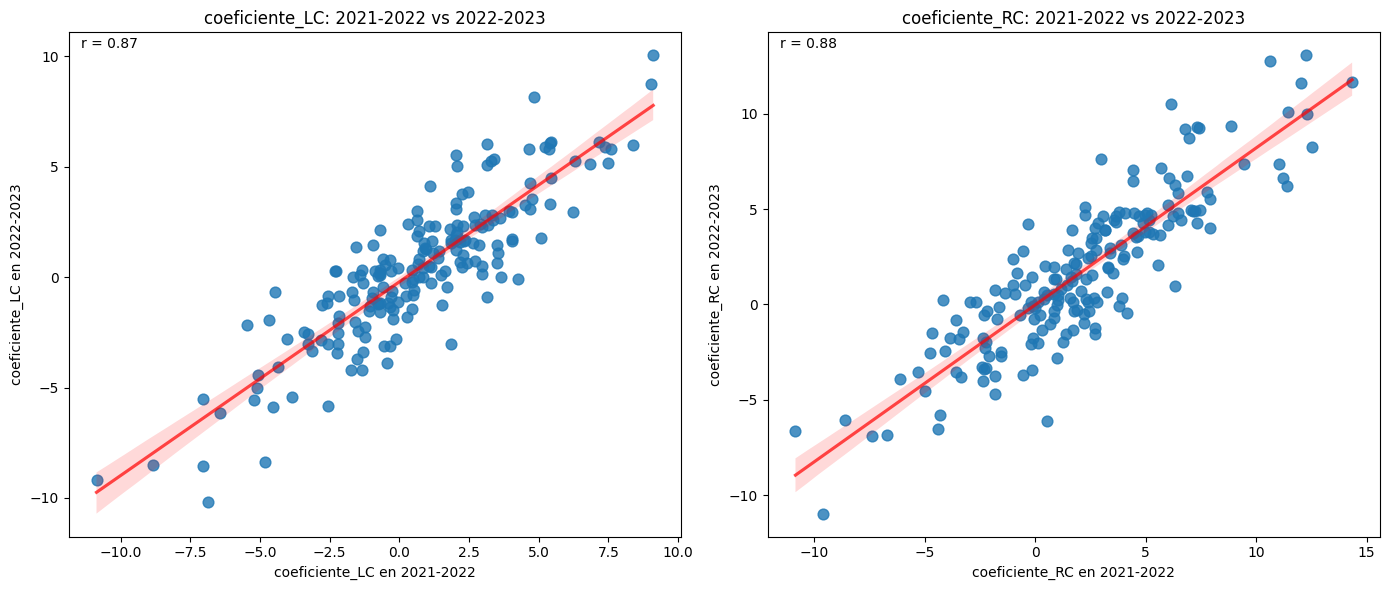

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

graficar_correlacion_periodos(data, 'coeficiente_LC', ax=axes[0])
graficar_correlacion_periodos(data, 'coeficiente_RC', ax=axes[1])

plt.tight_layout()
plt.savefig(EXPORT_PATH + "correlacion_interanual_va.png")
plt.show()

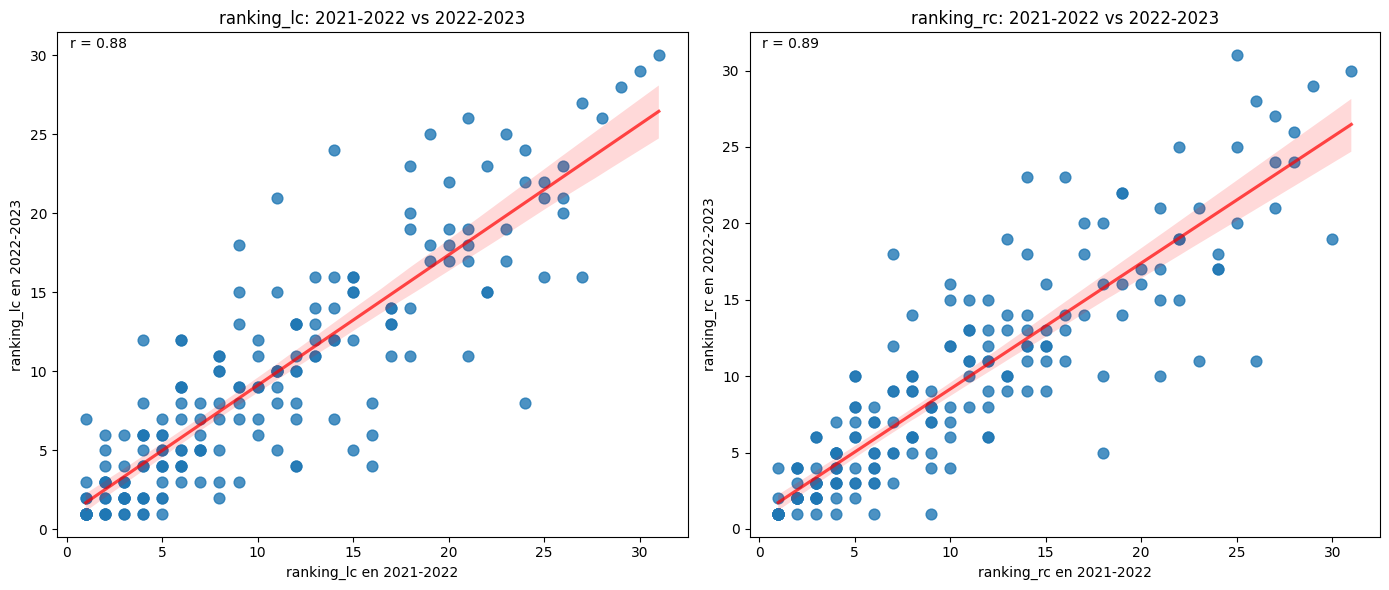

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

graficar_correlacion_periodos(data, 'ranking_lc', ax=axes[0])
graficar_correlacion_periodos(data, 'ranking_rc', ax=axes[1])

plt.tight_layout()
plt.savefig(EXPORT_PATH + "correlacion_ranking_interanual_va.png")
plt.show()

In [10]:
data.query("cine_f_2013_ac_campo_especific=='Industria y procesamiento'")[["periodo","ranking_rc", "coeficiente_RC", "nombre_institucion"]].sort_values(["periodo","ranking_rc"])

,periodo,ranking_rc,coeficiente_RC,nombre_institucion
153,2021-2022,1.0,7.79,Universidad Nacional De Colombia
368,2022-2023,1.0,5.90,Universidad Nacional De Colombia


/tmp/ipykernel_23484/1896725854.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.05, 0, 1, 0.98])


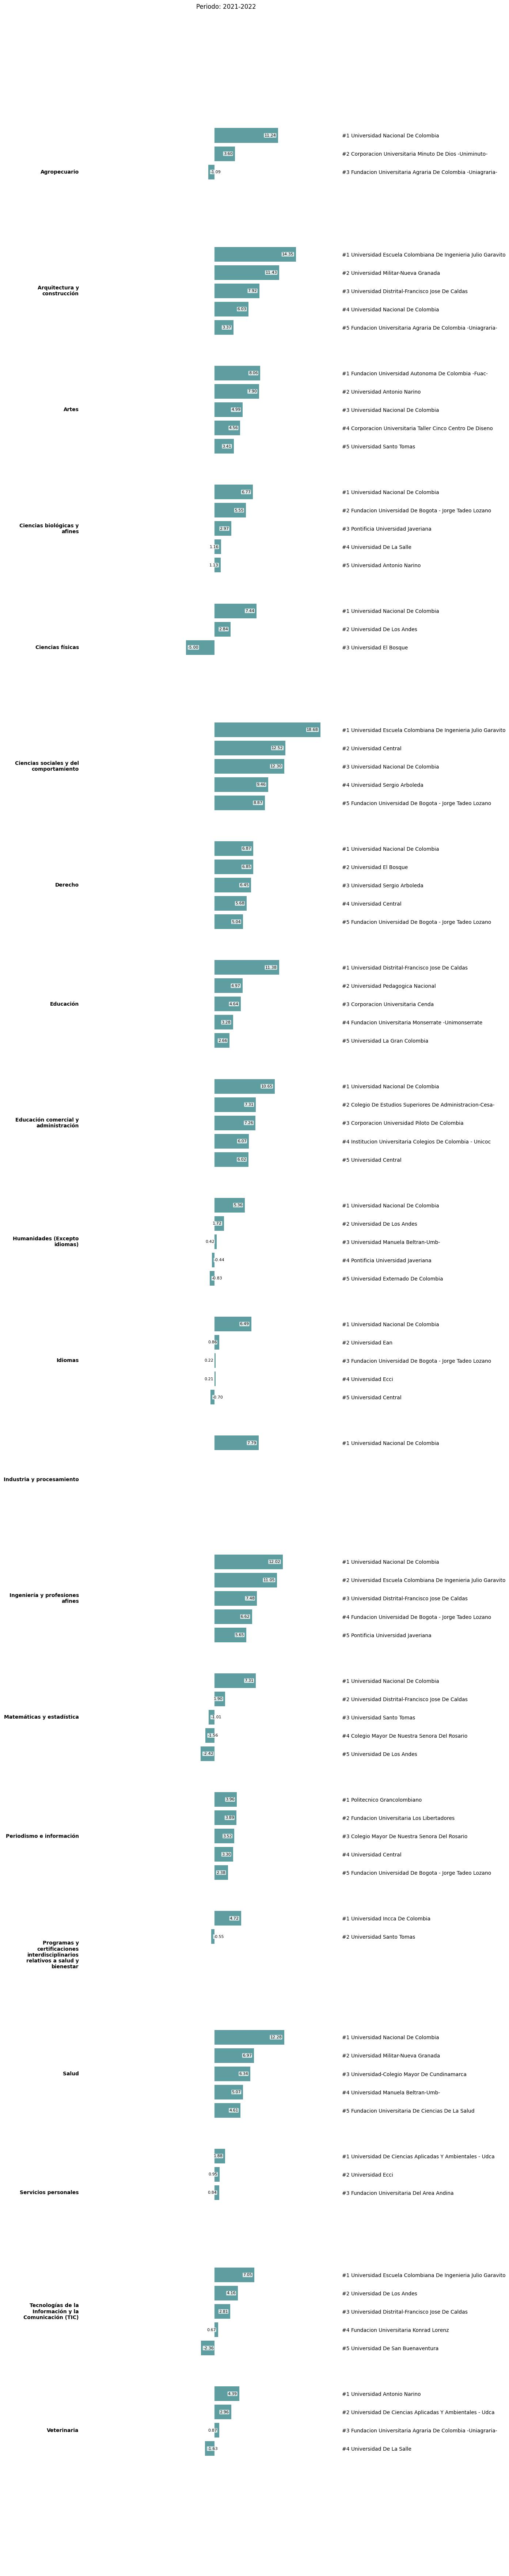

/tmp/ipykernel_23484/1896725854.py:199: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.05, 0, 1, 0.98])


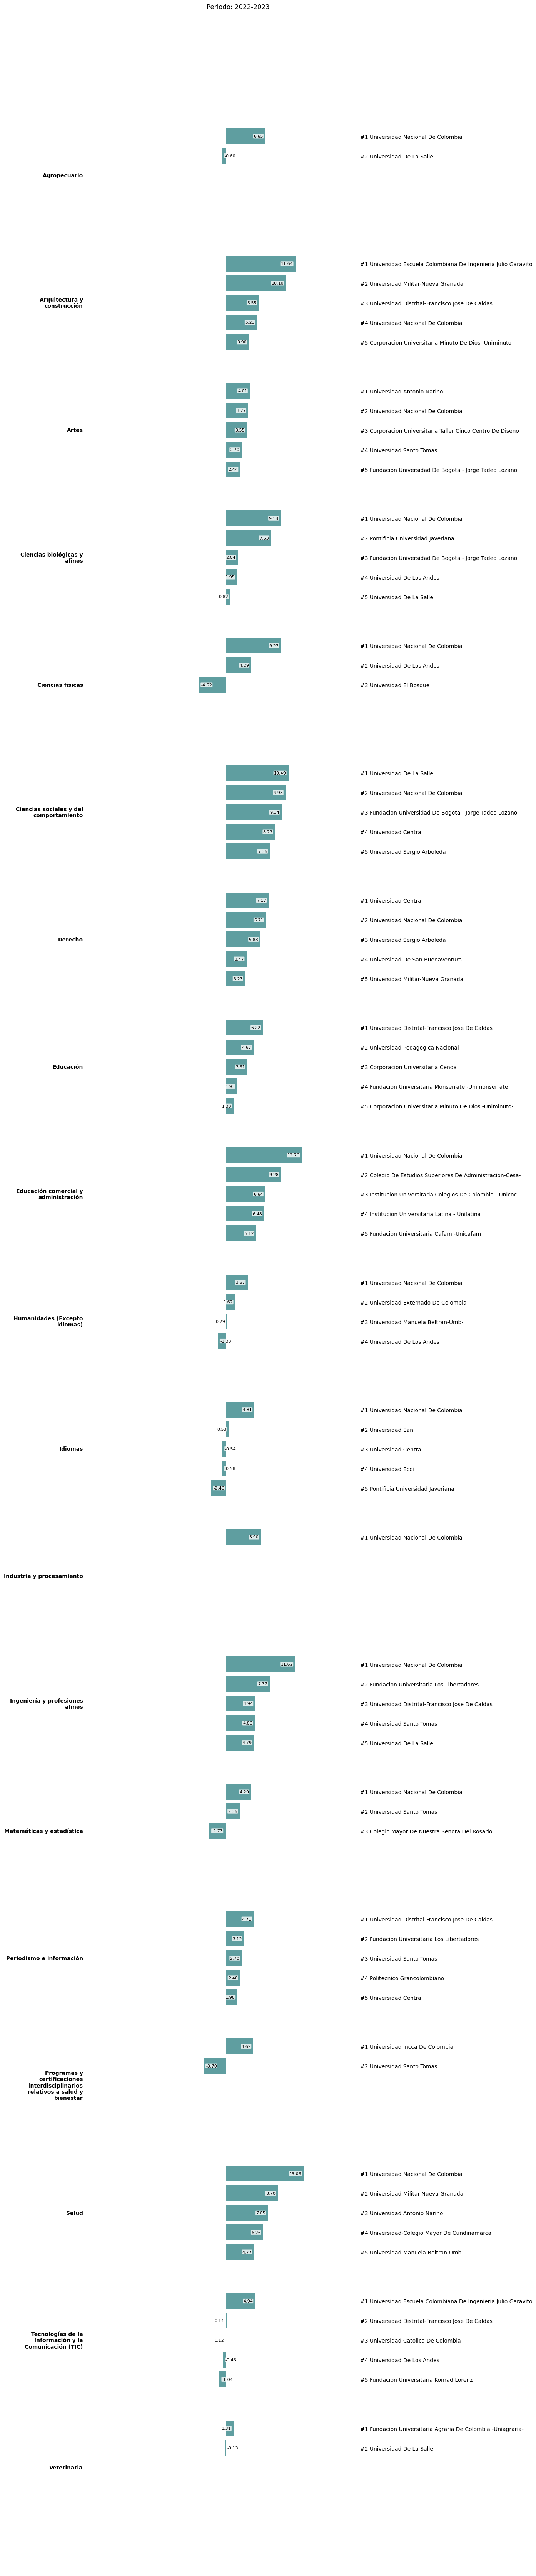

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import textwrap # Para dividir texto en múltiples líneas

def plot_single_year_top_coefficients(df, year, coeficiente_col, ranking_col, num_top=5,
                                      x_lim_min=None, x_lim_max=None, panel_alignment='right',
                                      cine_label_max_len=25):
    """
    Genera un único panel de gráfico de barras horizontales mostrando los coeficientes
    de las entidades top-rankeadas por categoría CINE para un año específico.
    Asegura la alineación vertical de las categorías, incluso si tienen menos de num_top
    observaciones. La alineación de barras y etiquetas de institución se controla
    para simular un panel izquierdo o derecho en una visualización comparativa.

    Parámetros:
    - df: DataFrame completo con los datos (debe contener 'periodo', 'cine_f_2013_ac_campo_especific',
          'nombre_institucion', 'icine', coeficiente_col, ranking_col).
          Se asume que 'ranking_col' ya ha sido calculado (e.g., con method='dense').
          Es crucial que 'icine' sea un identificador único para las instituciones.
    - year: El año específico (ej. '2021-2022' o '2022-2023') para el que se desea el gráfico.
    - coeficiente_col: Nombre de la columna que contiene los valores de los coeficientes (ej., 'coeficiente_RC').
    - ranking_col: Nombre de la columna que contiene el ranking (ej., 'ranking_rc').
                   Debe ser un valor numérico donde 1 es el mejor ranking.
    - num_top: Número de las top entidades a mostrar por cada categoría.
    - x_lim_min: Límite mínimo opcional para el eje X. Útil para mantener la misma escala entre gráficos.
    - x_lim_max: Límite máximo opcional para el eje X. Útil para mantener la misma escala entre gráficos.
    - panel_alignment: 'left' para un panel donde barras y etiquetas van a la izquierda
                       (para el período 2021-2022); 'right' para el panel derecho.
    - cine_label_max_len: Longitud máxima de la etiqueta de categoría CINE antes de dividirse en 2 líneas.

    Retorna:
    - fig: El objeto Figure de Matplotlib.
    - ax: El objeto Axes de Matplotlib.
    """

    df_year = df[df['periodo'] == year].copy()

    if df_year.empty:
        print(f"Advertencia: No hay datos para el período {year}. Se devolverá un gráfico vacío.")
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_title(f'Periodo: {year} (Sin Datos)', fontsize=12)
        ax.set_visible(False) # Make axes invisible if no data
        return fig, ax

    cine_categories = sorted(df_year['cine_f_2013_ac_campo_especific'].dropna().unique())

    # Si no se proporcionan límites, calcularlos del DataFrame completo para consistencia
    if x_lim_min is None:
        overall_min_coef = df[coeficiente_col].min()
        x_lim_min = overall_min_coef - 0.1 * (df[coeficiente_col].max() - overall_min_coef)
    if x_lim_max is None:
        overall_max_coef = df[coeficiente_col].max()
        x_lim_max = overall_max_coef + 0.1 * (overall_max_coef - df[coeficiente_col].min())

    # --- 1. Pre-define una Estructura Maestra del Eje Y para TODOS los slots posibles ---
    master_plot_data = []
    
    current_y_pos_tracker = 0
    # Guardamos las posiciones Y centrales para las etiquetas CINE.
    # Estas son las posiciones Y donde deberían aparecer los títulos de las categorías CINE.
    cine_category_y_positions = {} 

    for cine in cine_categories:
        cine_category_y_positions[cine] = current_y_pos_tracker + (num_top - 1) / 2.0
        
        for slot_rank in range(1, num_top + 1): # Los rankings son 1-indexados (1 a num_top)
            master_plot_data.append({
                'cine_f_2013_ac_campo_especific': cine,
                'slot_rank': slot_rank,
                'y_pos': current_y_pos_tracker + (slot_rank - 1) # 0-indexado para graficar
            })
        current_y_pos_tracker += num_top + 1.5 # Añadir un espacio fijo después de cada bloque de categoría

    master_df_structure = pd.DataFrame(master_plot_data)

    # Calcular la altura dinámica de la figura
    fig_height = max(8, current_y_pos_tracker * 0.7) # Ajustar el multiplicador para el espaciado visual
    
    fig, ax = plt.subplots(figsize=(8, fig_height)) # Un solo panel

    # --- 2. Preparar los Datos para el Período Actual Fusionando con la Estructura Maestra ---
    current_period_data = df_year[(df_year[ranking_col] <= num_top)].copy()
    
    # Asegurar una única entrada por institución por (CINE, Ranking) para los top N.
    current_period_data_clean = current_period_data.sort_values(
        by=['cine_f_2013_ac_campo_especific', ranking_col, coeficiente_col, 'nombre_institucion'],
        ascending=[True, True, False, True]
    ).drop_duplicates(subset=['cine_f_2013_ac_campo_especific', ranking_col], keep='first')

    plot_df_for_panel = pd.merge(
        master_df_structure,
        current_period_data_clean[['cine_f_2013_ac_campo_especific', 'nombre_institucion', coeficiente_col, ranking_col]],
        left_on=['cine_f_2013_ac_campo_especific', 'slot_rank'],
        right_on=['cine_f_2013_ac_campo_especific', ranking_col],
        how='left',
        suffixes=('', '_data')
    )
    if ranking_col + '_data' in plot_df_for_panel.columns:
        plot_df_for_panel = plot_df_for_panel.drop(columns=[ranking_col + '_data'])

    plot_df_for_panel = plot_df_for_panel.sort_values(by='y_pos')
    
    plot_df_valid_bars = plot_df_for_panel.dropna(subset=[coeficiente_col]).copy()

    # --- 3. Trazado de Barras y Etiquetas de Coeficientes ---
    if not plot_df_valid_bars.empty:
        # Trazar las barras
        ax.barh(plot_df_valid_bars['y_pos'], plot_df_valid_bars[coeficiente_col], color='#5f9ea0', height=0.8)

        # Añadir etiquetas de texto para los coeficientes
        for _, row in plot_df_valid_bars.iterrows():
            xval = row[coeficiente_col]
            yval = row['y_pos']
            
            text_offset = 0.01 * (x_lim_max - x_lim_min)
            
            if panel_alignment == 'left':
                ha_align = 'left' if xval >= 0 else 'right'
                text_x = xval + text_offset if xval >= 0 else xval - text_offset
            else: # 'right' alignment
                ha_align = 'right' if xval >= 0 else 'left'
                text_x = xval - text_offset if xval >= 0 else xval + text_offset

            ax.text(text_x, yval, f'{xval:.2f}',
                    va='center', ha=ha_align,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle="round,pad=0.1"),
                    fontsize=8)
    
    ax.set_title(f'Periodo: {year}', loc='center', fontsize=12)
    
    # --- Configurar los límites del eje X según la alineación del panel ---
    if panel_alignment == 'left':
        ax.set_xlim(x_lim_max, x_lim_min) # Invertir el eje X para barras a la izquierda
    else: # 'right'
        ax.set_xlim(x_lim_min, x_lim_max) # Eje X normal

    # --- Configurar las Marcas y Etiquetas del Eje Y (Nombres de Instituciones) ---
    ax.set_yticks(plot_df_for_panel['y_pos'])
    
    current_labels = []
    for idx, row in plot_df_for_panel.iterrows():
        if pd.notna(row['nombre_institucion']):
            # Formato: #Ranking Nombre Institución
            label = f"#{int(row['slot_rank'])} {row['nombre_institucion']}"
            current_labels.append(label)
        else:
            current_labels.append('') # Espacio vacío para slots sin institución

    ax.set_yticklabels(current_labels)
    
    ax.tick_params(axis='y', length=0, pad=5) # Ocultar marcas, añadir padding

    if panel_alignment == 'left':
        ax.yaxis.tick_left() # Etiquetas a la izquierda del eje
        ax.yaxis.set_label_position("left")
    else: # 'right'
        ax.yaxis.tick_right() # Etiquetas a la derecha del eje
        ax.yaxis.set_label_position("right")
    
    ax.invert_yaxis() # Los elementos superiores primero en el gráfico
    
    # Eliminar spines y x-ticks para una apariencia más limpia
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])

    # --- 4. Añadir las etiquetas de la categoría CINE (se colocarán a la izquierda de la barra Y-labels) ---
    for cine_cat_raw in cine_categories:
        y_pos_label = cine_category_y_positions[cine_cat_raw]
        
        # Dividir la etiqueta de la categoría CINE si es muy larga
        wrapped_cine_cat = textwrap.fill(cine_cat_raw, width=cine_label_max_len)

        # Posicionamiento de la etiqueta CINE
        if panel_alignment == 'left':
            # Para el panel izquierdo, las etiquetas CINE deben estar a la derecha de las etiquetas de univ.
            # es decir, más cerca del centro si se pegaran los gráficos.
            # Se usa `ax.get_xlim()[0]` para el borde izquierdo del eje actual (que sería el x_lim_max si invertido).
            # Se ajusta el offset para que no choque con las etiquetas de la universidad.
            x_label_pos = ax.get_xlim()[0] + (x_lim_max - x_lim_min) * 0.15 # Ajustar este valor
            ha_align_label = 'left' # Alineación de texto
        else: # 'right' alignment
            # Para el panel derecho, las etiquetas CINE deben estar a la izquierda de las etiquetas de univ.
            x_label_pos = ax.get_xlim()[0] - (x_lim_max - x_lim_min) * 0.15 # Ajustar este valor
            ha_align_label = 'right'

        ax.text(x_label_pos,
                y_pos_label,
                wrapped_cine_cat,
                ha=ha_align_label, va='center', fontsize=10, fontweight='bold',
                transform=ax.transData,
                clip_on=False) # Permite que el texto se dibuje fuera del área de trazado

    # Ajustar el layout para dar espacio a las etiquetas CINE que están fuera del área de trazado
    plt.tight_layout(rect=[0.05, 0, 1, 0.98]) 
    
    return fig, ax


# Asegúrate de que tu DataFrame 'data' esté cargado y con los rankings calculados.
# Por ejemplo, si usas 'ranking_rc':
# data['ranking_rc'] = data.groupby(['cine_f_2013_ac_campo_especific', 'periodo'])['coeficiente_RC'] \
#                          .rank(method='dense', ascending=False)


# --- Paso 1: Calcular los límites globales del eje X una sola vez ---
# Esto es crucial para que ambos gráficos tengan la misma escala y sean comparables.
global_min_coef = data['coeficiente_RC'].min()
global_max_coef = data['coeficiente_RC'].max()
# Añadir un buffer para que las barras y etiquetas no queden pegadas a los bordes
x_buffer = 0.1 * (global_max_coef - global_min_coef)
shared_x_min = global_min_coef - x_buffer
shared_x_max = global_max_coef + x_buffer


# --- Paso 2: Llamar la función para el primer período (2021-2022) ---
fig1, ax1 = plot_single_year_top_coefficients(
    df=data,
    year='2021-2022',
    coeficiente_col='coeficiente_RC',
    ranking_col='ranking_rc',
    num_top=5,
    x_lim_min=shared_x_min, # Usar el límite mínimo compartido
    x_lim_max=shared_x_max  # Usar el límite máximo compartido
)
# Puedes guardar esta primera figura si lo deseas:
fig1.savefig(EXPORT_PATH +'grafico_2021_2022.png', bbox_inches='tight')
plt.show() # Muestra el primer gráfico


# --- Paso 3: Llamar la función para el segundo período (2022-2023) ---
fig2, ax2 = plot_single_year_top_coefficients(
    df=data,
    year='2022-2023',
    coeficiente_col='coeficiente_RC',
    ranking_col='ranking_rc',
    num_top=5,
    x_lim_min=shared_x_min, # Usar el límite mínimo compartido
    x_lim_max=shared_x_max  # Usar el límite máximo compartido
)
# Puedes guardar esta segunda figura si lo deseas:
fig2.savefig(EXPORT_PATH + 'grafico_2022_2023.png', bbox_inches='tight')
plt.show() # Muestra el segundo gráfico


# Una vez que tengas estos dos archivos de imagen (o los veas en tu entorno),
# puedes importarlos a un editor de imágenes o a un documento para pegarlos lado a lado
# y crear la comparación final.

## Intervalos de confianza

In [10]:
df = data.query("periodo=='2022-2023'").copy()

In [11]:
df.cine_f_2013_ac_campo_especific.nunique()

19

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_efecto_rc_by_category(
    df: pd.DataFrame,
    category_column: str = 'cine_f_2013_ac_campo_especific',
    institution_id_column: str = 'codigo_institucion',
    effect_value_column: str = 'efecto_rc',
    lower_bound_column: str = 'ic_inf_rc',
    upper_bound_column: str = 'ic_sup_rc'
):
    """
    Genera gráficos del valor agregado de razonamiento cuantitativo (efecto_rc)
    con sus intervalos de confianza para cada institución dentro de cada categoría.

    Omite las filas con valores NaN en las columnas relevantes para la graficación.
    Los gráficos se ordenan por efecto_rc de forma ascendente y muestran
    el código de la institución en el eje X (tratado como categoría explícita).

    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene los datos.
    category_column (str): Nombre de la columna que contiene las categorías.
    institution_id_column (str): Nombre de la columna con el identificador de la institución.
    effect_value_column (str): Nombre de la columna con el valor puntual (ej. 'efecto_rc').
    lower_bound_column (str): Nombre de la columna con el límite inferior del IC.
    upper_bound_column (str): Nombre de la columna con el límite superior del IC.
    """

    unique_categories = df[category_column].unique()
    print(f"Generando {len(unique_categories)} gráficos para las categorías en '{category_column}'...\n")

    # Columnas clave para el ploteo
    plot_columns = [
        institution_id_column,
        effect_value_column,
        lower_bound_column,
        upper_bound_column
    ]

    for category in unique_categories:
        # Filtrar el DataFrame para la categoría actual
        df_filtered = df[df[category_column] == category].copy()

        # --- Omitir filas con NaN en las columnas relevantes para el gráfico ---
        initial_rows = len(df_filtered)
        df_filtered.dropna(subset=plot_columns, inplace=True)
        if len(df_filtered) < initial_rows:
            print(f"  Nota: Se omitieron {initial_rows - len(df_filtered)} filas con NaN para la categoría '{category}'.")
        # -------------------------------------------------------------------------

        if df_filtered.empty:
            print(f"  Advertencia: No hay datos válidos para graficar en la categoría '{category}' después de omitir NaNs. Saltando esta categoría.")
            continue # Salta a la siguiente categoría si no quedan datos

        # Ordenar los datos por el valor de 'efecto_rc' de forma ascendente
        df_filtered = df_filtered.sort_values(by=effect_value_column, ascending=True)

        # Obtener el orden de los códigos de institución para el eje X
        # Esto asegura que el eje X sea categórico y esté ordenado por efecto_rc
        ordered_institutions = df_filtered[institution_id_column].tolist()

        # Crear la figura y los ejes para el gráfico
        plt.figure(figsize=(12, 6)) # Ajusta el tamaño según necesites

        # 1. Graficar los valores puntuales (los puntos)
        # Es crucial que el 'x' aquí sea el índice del DataFrame ordenado,
        # y luego usaremos los 'ordered_institutions' para las etiquetas.
        sns.scatterplot(
            x=range(len(df_filtered)), # Usamos el índice para el posicionamiento
            y=df_filtered[effect_value_column],
            color='skyblue',
            s=100, # Tamaño de los puntos
            label=f'Valor Puntual ({effect_value_column})',
            zorder=2
        )

        # 2. Añadir los intervalos de confianza (los bigotes)
        yerr_lower = df_filtered[effect_value_column] - df_filtered[lower_bound_column]
        yerr_upper = df_filtered[upper_bound_column] - df_filtered[effect_value_column]

        plt.errorbar(
            x=range(len(df_filtered)), # Usamos el índice para el posicionamiento
            y=df_filtered[effect_value_column],
            yerr=[yerr_lower, yerr_upper],
            fmt='none', # No dibujar un marcador adicional, solo los bigotes
            capsize=5,  # Tamaño de las "gorras" en los extremos de los bigotes
            color='darkgray', # Color más oscuro para los bigotes
            alpha=0.9, # Mayor opacidad para hacerlos más visibles
            label='Intervalo de Confianza',
            zorder=1
        )

        # --- ¡Nuevo! Añadir la línea verde en y=0 ---
        plt.axhline(y=0, color='green', linestyle='--', linewidth=1.5, label='Línea de Referencia (y=0)')
        # ---------------------------------------------

        plt.title(f'Valor Agregado de Razonamiento Cuantitativo por Institución\nCategoría: {category}', fontsize=14)
        plt.xlabel(f'{institution_id_column} (Código de Institución)', fontsize=12)
        plt.ylabel(f'{effect_value_column}', fontsize=12)

        # --- ¡Nuevo y crucial! Establecer explícitamente las marcas y etiquetas del eje X ---
        plt.xticks(ticks=range(len(df_filtered)), labels=ordered_institutions, rotation=90)
        # -----------------------------------------------------------------------------------

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout() # Ajustar el diseño para evitar solapamiento
        #plt.savefig(EXPORT_PATH + "va_rc_con_intervalos_de_confianza_2022_2023.png")
        plt.show()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Necesario para np.ceil

def plot_efecto_rc_matrix_by_category(
    df: pd.DataFrame,
    category_column: str = 'cine_f_2013_ac_campo_especific',
    institution_id_column: str = 'codigo_institucion',
    effect_value_column: str = 'efecto_rc',
    lower_bound_column: str = 'ic_inf_rc',
    upper_bound_column: str = 'ic_sup_rc',
    cols_per_row: int = 4 # Número de columnas en la matriz de subplots
):
    """
    Genera una matriz de subplots mostrando el valor agregado de razonamiento cuantitativo (efecto_rc)
    con sus intervalos de confianza para cada institución dentro de cada categoría.

    Incluye una línea verde en y=0 como referencia.
    Omite las filas con valores NaN en las columnas relevantes para la graficación.
    Los gráficos se ordenan por efecto_rc de forma ascendente y muestran
    el código de la institución en el eje X (tratado como categoría explícita).

    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene los datos.
    category_column (str): Nombre de la columna que contiene las categorías.
    institution_id_column (str): Nombre de la columna con el identificador de la institución.
    effect_value_column (str): Nombre de la columna con el valor puntual (ej. 'efecto_rc').
    lower_bound_column (str): Nombre de la columna con el límite inferior del IC.
    upper_bound_column (str): Nombre de la columna con el límite superior del IC.
    cols_per_row (int): Número de gráficos por fila en la matriz.
    """

    unique_categories = df[category_column].unique()
    num_categories = len(unique_categories)

    # Calcular el número de filas necesario para la matriz de subplots
    n_rows = int(np.ceil(num_categories / cols_per_row))
    n_cols = cols_per_row

    # Crear la figura y el conjunto de subplots
    # Ajustar el tamaño general de la figura para acomodar todos los subplots
    # (ancho_por_col * n_cols, alto_por_fila * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows), squeeze=False)
    # squeeze=False asegura que 'axes' siempre sea un array 2D, incluso para 1x1

    # Aplanar el array de ejes para facilitar la iteración
    axes = axes.flatten()

    print(f"Generando {num_categories} gráficos en una matriz de {n_rows}x{n_cols}...\n")

    # Columnas clave para el ploteo
    plot_columns = [
        institution_id_column,
        effect_value_column,
        lower_bound_column,
        upper_bound_column
    ]

    for i, category in enumerate(unique_categories):
        ax = axes[i] # Seleccionar el eje actual para graficar

        # Filtrar el DataFrame para la categoría actual
        df_filtered = df[df[category_column] == category].copy()

        # --- Omitir filas con NaN en las columnas relevantes para el gráfico ---
        initial_rows = len(df_filtered)
        df_filtered.dropna(subset=plot_columns, inplace=True)
        if len(df_filtered) < initial_rows:
            print(f"  Nota: Se omitieron {initial_rows - len(df_filtered)} filas con NaN para la categoría '{category}'.")
        # -------------------------------------------------------------------------

        if df_filtered.empty:
            print(f"  Advertencia: No hay datos válidos para graficar en la categoría '{category}' después de omitir NaNs. Saltando esta categoría.")
            # Si no hay datos, desactiva el eje para que no se muestre vacío
            ax.set_visible(False)
            continue # Salta a la siguiente categoría si no quedan datos

        # Ordenar los datos por el valor de 'efecto_rc' de forma ascendente
        df_filtered = df_filtered.sort_values(by=effect_value_column, ascending=True)

        # Obtener el orden de los códigos de institución para el eje X
        ordered_institutions = df_filtered[institution_id_column].tolist()

        # 1. Graficar los valores puntuales (los puntos)
        sns.scatterplot(
            x=range(len(df_filtered)), # Usamos el índice para el posicionamiento
            y=df_filtered[effect_value_column],
            color='skyblue',
            s=80, # Tamaño de los puntos ajustado para subplots
            label=f'Valor Puntual ({effect_value_column})',
            zorder=2,
            ax=ax # Especificar el eje para graficar
        )

        # 2. Añadir los intervalos de confianza (los bigotes)
        yerr_lower = df_filtered[effect_value_column] - df_filtered[lower_bound_column]
        yerr_upper = df_filtered[upper_bound_column] - df_filtered[effect_value_column]

        ax.errorbar( # Usar ax.errorbar
            x=range(len(df_filtered)), # Usamos el índice para el posicionamiento
            y=df_filtered[effect_value_column],
            yerr=[yerr_lower, yerr_upper],
            fmt='none', # No dibujar un marcador adicional, solo los bigotes
            capsize=4,  # Tamaño de las "gorras" ajustado para subplots
            color='darkgray', # Color más oscuro para los bigotes
            alpha=0.9, # Mayor opacidad para hacerlos más visibles
            label='Intervalo de Confianza',
            zorder=1
        )

        # Añadir la línea verde en y=0
        ax.axhline(y=0, color='green', linestyle='--', linewidth=1.0, label='Línea de Referencia (y=0)') # Usar ax.axhline

        ax.set_title(f'Categoría: {category}', fontsize=12) # Título específico para el subplot
        ax.set_xlabel(f'{institution_id_column}', fontsize=10) # Etiqueta X más pequeña
        ax.set_ylabel(f'{effect_value_column}', fontsize=10) # Etiqueta Y más pequeña

        # Establecer explícitamente las marcas y etiquetas del eje X
        ax.set_xticks(ticks=range(len(df_filtered)), labels=ordered_institutions, rotation=90) # Usar ax.set_xticks

        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(fontsize=8) # Leyenda más pequeña para subplots

    # Ocultar los subplots vacíos si el número de categorías no es un múltiplo exacto de cols_per_row
    for j in range(num_categories, len(axes)):
        axes[j].set_visible(False)

    # Título general de la figura
    fig.suptitle(f'Valor Agregado de {effect_value_column} por Institución (Por Categoría CINE)', fontsize=18, y=1.01) # y ajusta la posición del título
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar el diseño, dejando espacio para el super título
    plt.savefig(EXPORT_PATH + effect_value_column +"_va_ic_2022_2023.png")
    plt.show()

Generando 19 gráficos en una matriz de 5x4...



/home/alejandro/.virtualenvs/mainenv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


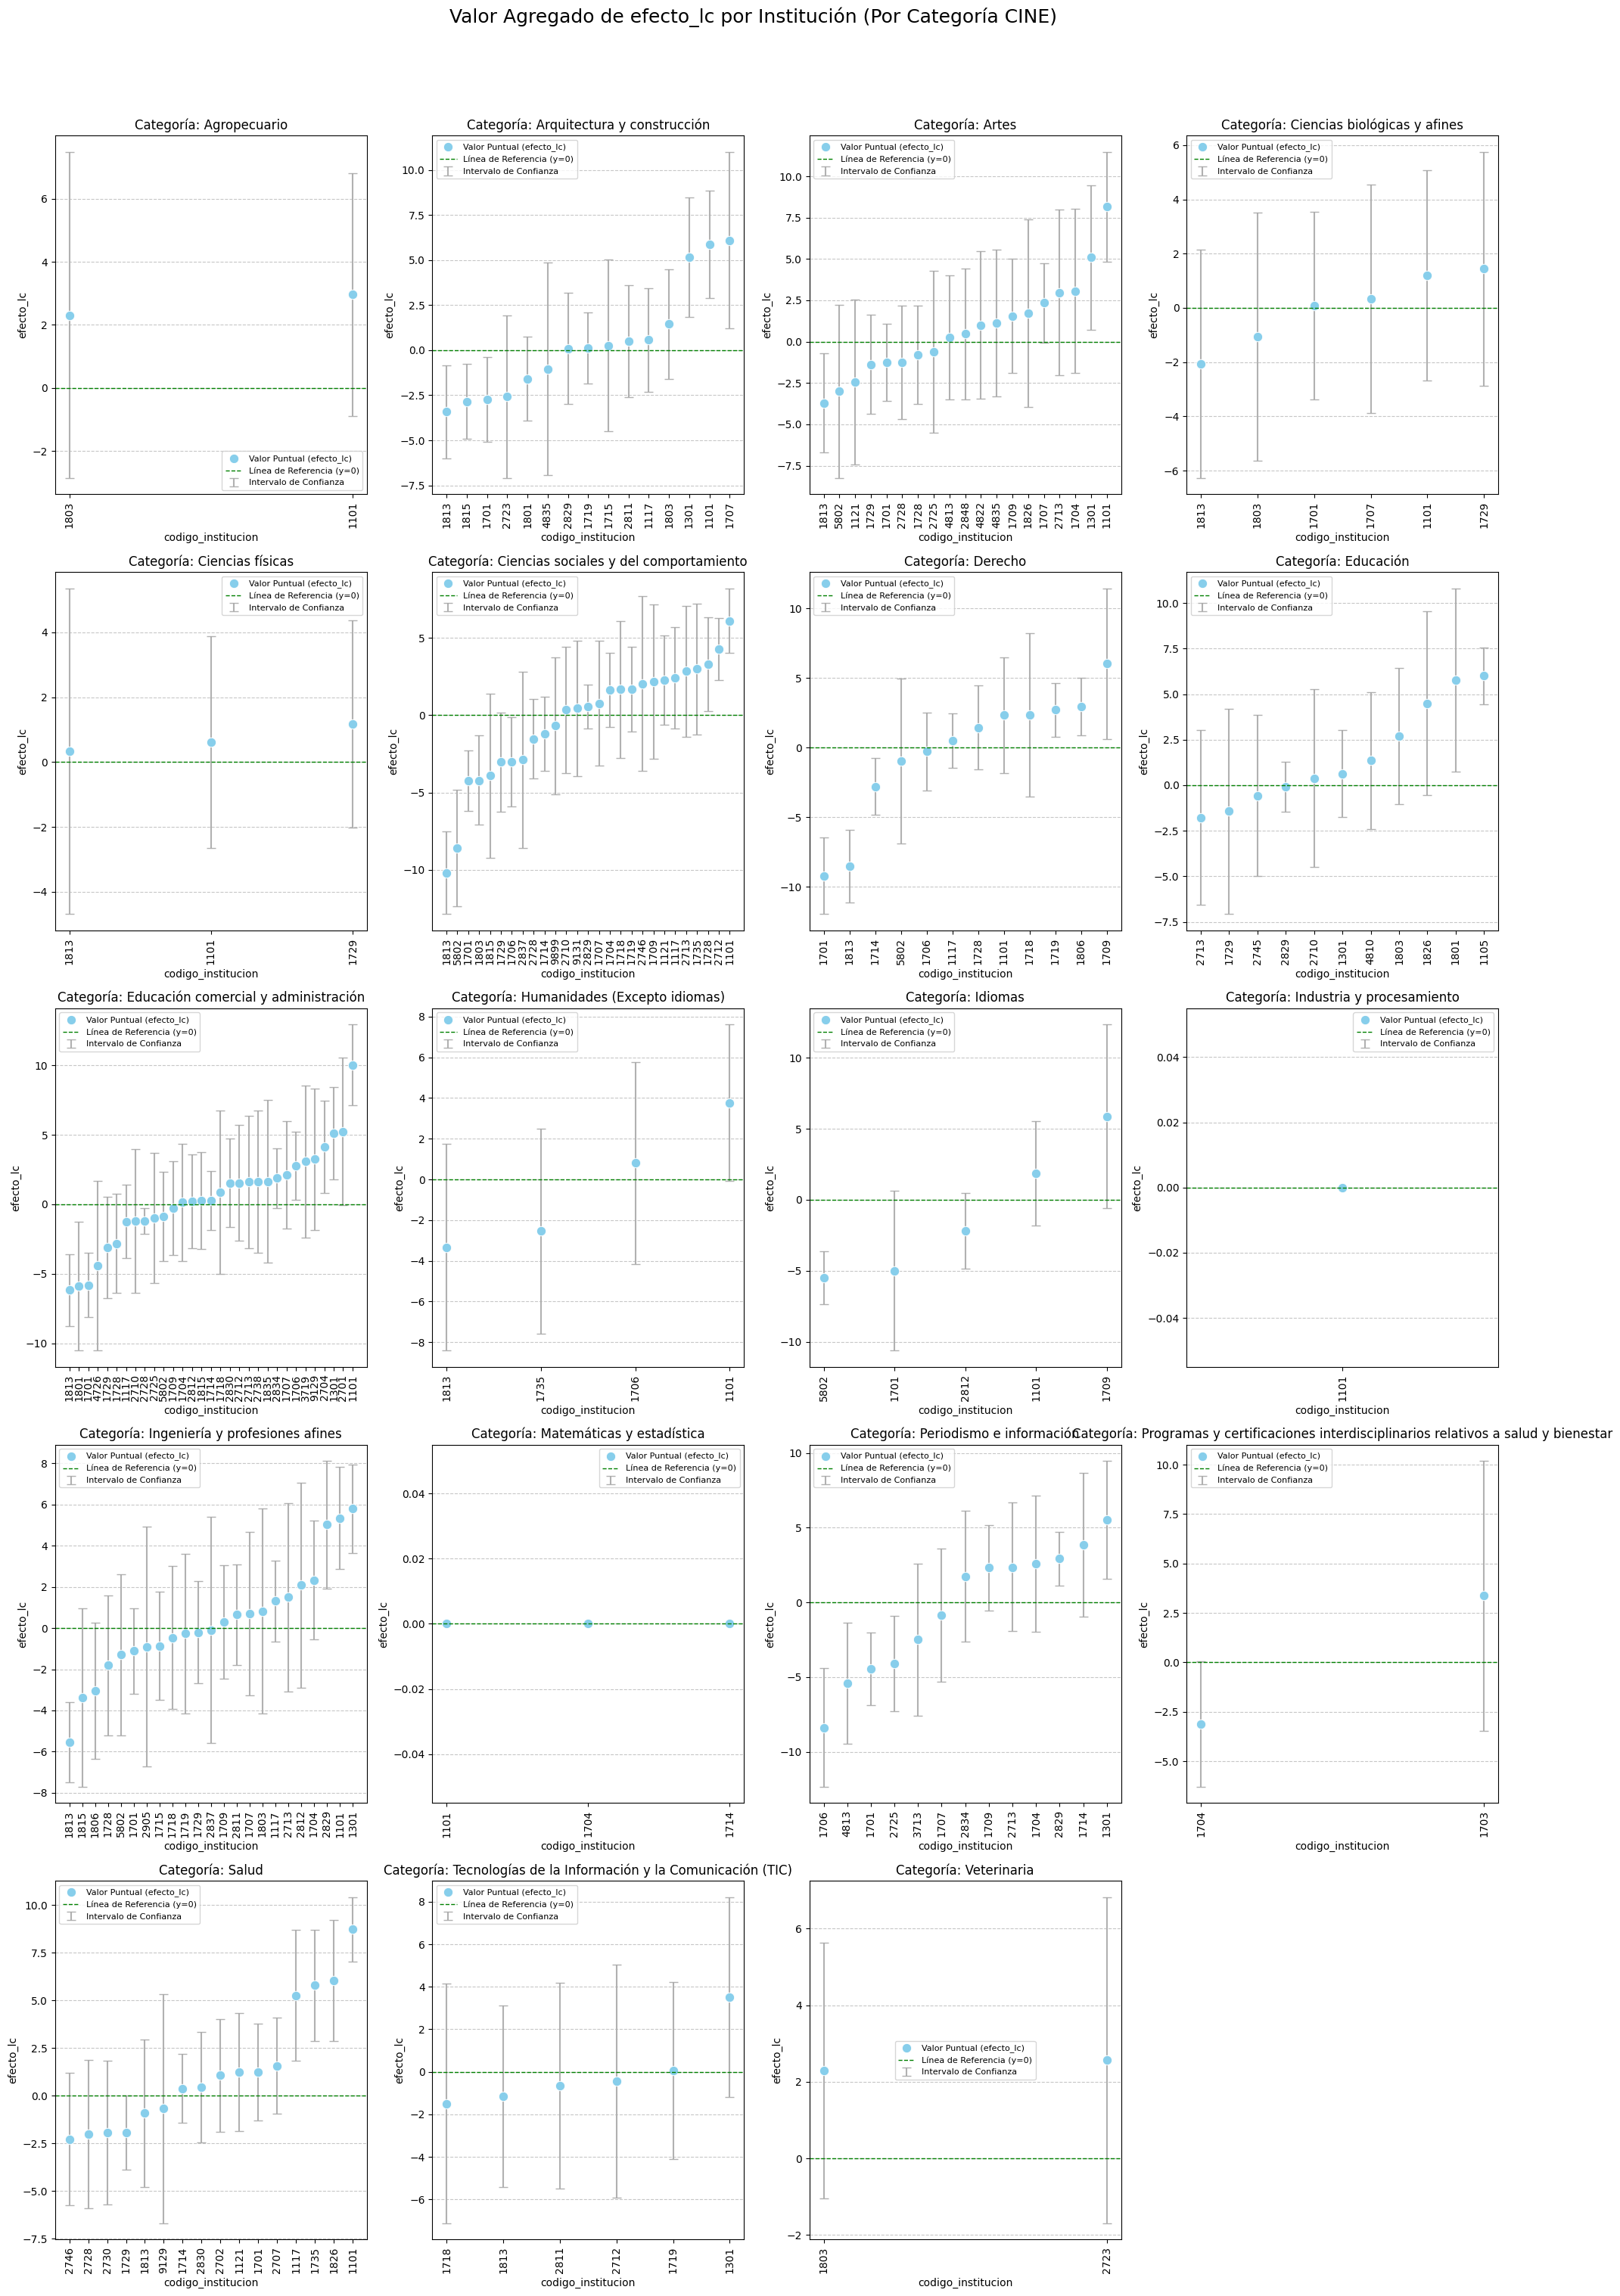

In [33]:
plot_efecto_rc_matrix_by_category(
    df,
    effect_value_column = "efecto_lc",
    lower_bound_column = "ic_inf_lc",
    upper_bound_column= "ic_sup_lc"
)

Generando 19 gráficos en una matriz de 5x4...



/home/alejandro/.virtualenvs/mainenv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


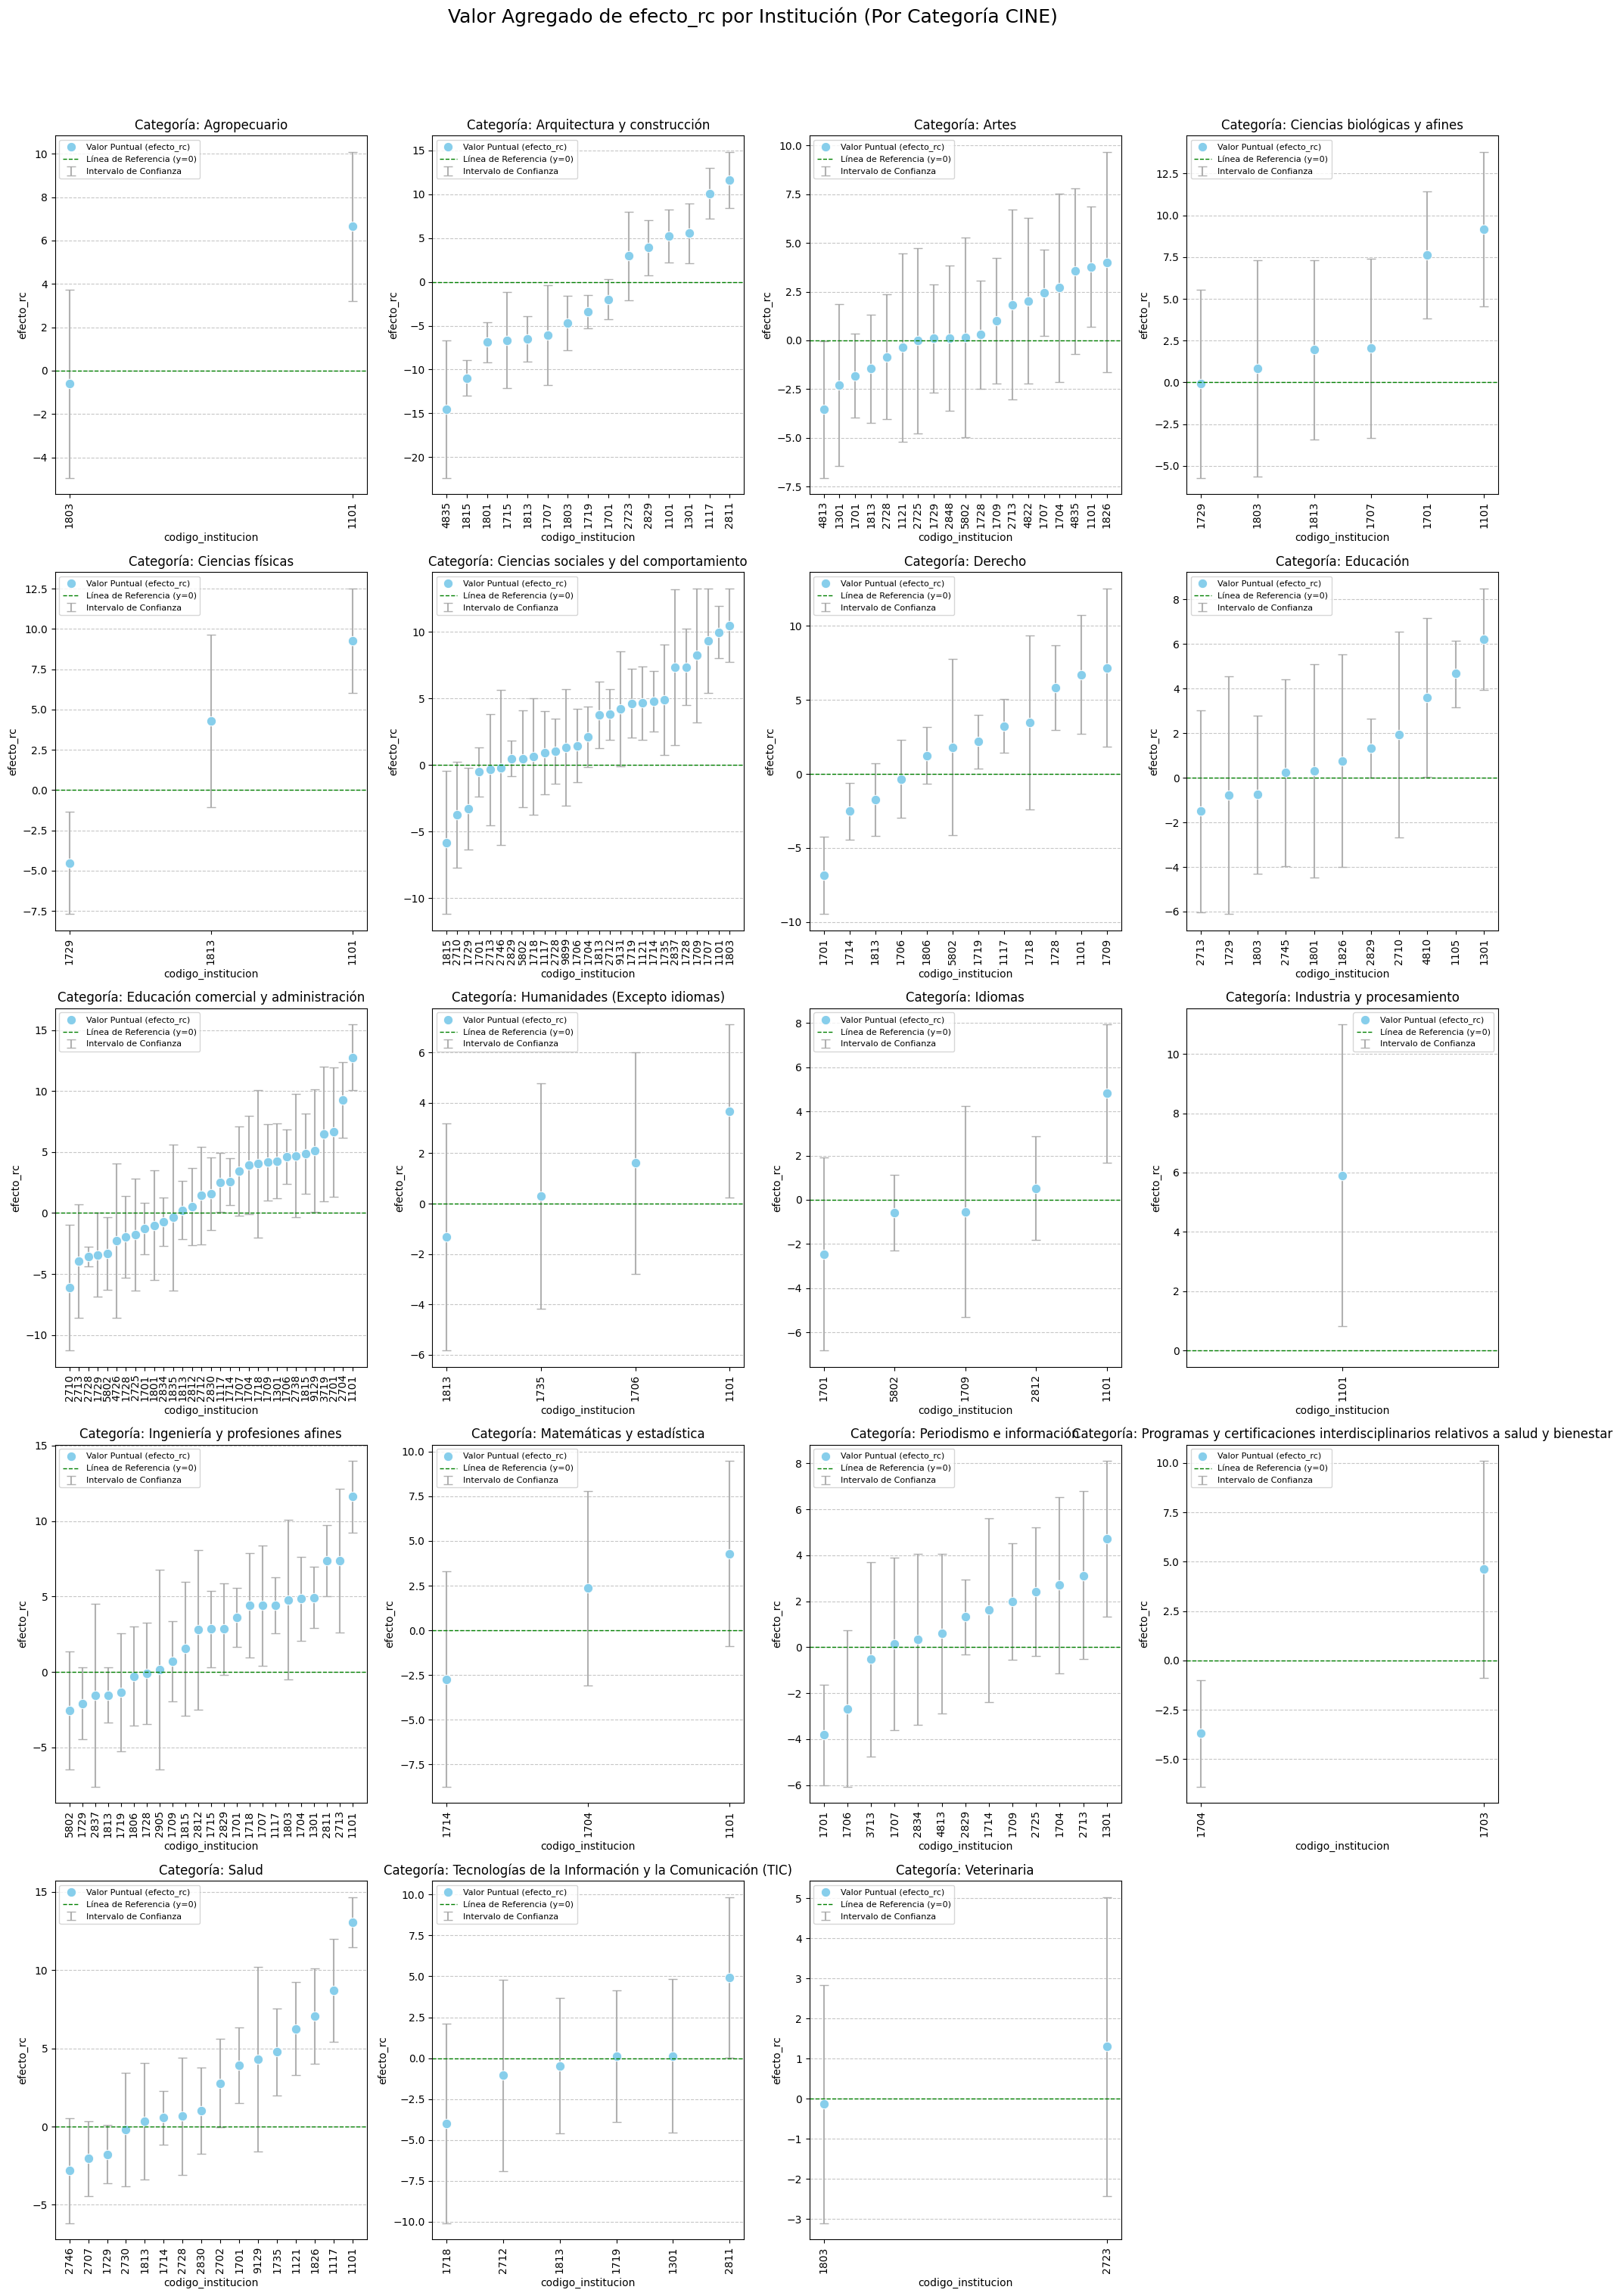

In [34]:
plot_efecto_rc_matrix_by_category(
    df,
    effect_value_column = "efecto_rc",
    lower_bound_column = "ic_inf_rc",
    upper_bound_column= "ic_sup_rc"
)